## **VISÃO COMPUTACIONAL - AULA 16**

**Objetivos da aula:**

*   conhecer o modelo de câmera pinhole
*   praticar com calibração de câmeras pinhole com padrão de calibração
*   tratar problemas de distorção de imagens para calibração



### **MODELO DE CÂMERA PINHOLE**

Um dos elementos centrais no processo de geração de imagens são as câmeras. Imagens percebidas por uma câmera são projeções de objetos 3D no plano da imagem.

<img src="https://storage.googleapis.com/tensorflow-graphics/notebooks/intrinsics/camera_model.jpg"> </img>

A especificação de uma câmera consiste de parâmetros extrínsecos (posição, ponto focal) e intrínsecos (tamanho do plano de imagem, abertura, distância focal). 

Uma câmara estenopeica ou câmara pinhole é uma máquina fotográfica sem lente. A designação tem por base o inglês, pin-hole, "buraco de alfinete" e é usada para referir a fotografia estenopeica. Este tipo de fotografia é uma prática econômica e simples pois utiliza uma caixa qualquer em que a luz não penetre. A existência de um pequeno furo (do grego stenós, estreito) é o que em português permite designar este tipo de fotografia por fotografia estenopeica.

A pinhole consiste numa maneira de ver uma imagem real através de uma câmara escura. De um pequeno orifício onde a luz é captada para dentro da câmara, e sofrendo um movimento de inversão, a imagem é projetada para a parede oposta ao orifício ao contrário. Para produzir uma imagem razoavelmente nítida, a abertura tem que ser um furo pequeno, na ordem de 0,5 mm ou menos. O obturador da câmara pinhole geralmente consiste de uma mão espalmada ou de algum material à prova de luz para cobrir e descobrir o furo. As câmaras pinhole requerem um tempo maior de exposição do que as câmaras convencionais, devido à pequena abertura; os tempos de exposição vão de 5 segundos a muitas horas.

<img src="https://lhoangan.github.io/assets/images/posts/2018-07-30/pinhole_camera.png"> </img>

A imagem pode ser projetada em uma tela translúcida para visualização em tempo real (popularmente utilizadas para ver eclipses solares), ou pode expor filme ou um dispositivo de carga acoplado (CCD). As câmaras pinhole com CCD são algumas vezes utilizadas em serviço de vigilância, devido a seu tamanho pequeno.

Os parâmetros do modelo de câmera pinhole são mostrados  abaixo:

<img src="https://lhoangan.github.io/assets/images/posts/2018-07-30/camera_model.png"> </img>

Podemos relacionar as coordenadas $(X,Y,Z)$ dos objetos com coordenadas $(u,v)$ na imagem usando a seguinte matriz de projeção:

<img src="https://visualservoing.files.wordpress.com/2012/04/pinhole-model-formula.jpg"> </img>

Nesta matriz, $(c_{x},c_{y})$ representa o centro do plano da imagem, chamado de centro focal e $(f_{x},f_{y})$ as distâncias focais (normalmente, assumimos que $f_{x}=f_{y}=f$. 
    
       










#### <b> EXERCÍCIO </b>

Suponha uma câmera pinhole posicionada na origem, com foco segundo o eixo z, com distância focal f=2 e centro focal (0,0). Obtenha as coordenadas do pixel no plano da imagem produzidas pelo ponto 3D de coordenadas (3,2,5).

In [1]:
#implemente seu código aqui

import numpy as np

camera = np.array([[2,0,0],
                  [0,2,0],
                  [0,0,1]])
ponto=np.array([3,2,5]);
Z = 5
imagem=np.matmul(camera,ponto)/Z

imagem

array([1.2, 0.8, 1. ])

### <b> CALIBRAÇÃO DE CÂMERAS </b>

O <b> problema da calibração de câmera 3D </b> consiste em: dadas uma ou mais imagens de uma cena, encontrar o valor das parâmetros da matriz de projeção da câmera $c_{x},c_{y},f_{x},f_{y}$. No processo de calibração, podemos usar uma, duas, três ou mais imagens. 

Nesta aula, trablharemos apenas com uma imagem para calibração. Para isto, nos orientaremos pelas linhas do tabuleiro, conforme mostrado abaixo:

<img src="https://docs.opencv.org/3.4/calib_radial.jpg"> </img>

Devido à distorção das lentes, as linhas nem sempre estarão "retas". Posteriormente, vamos corrigir esta distorção.

No código abaixo, vamos identificar 42 (7x6) corners em cada imagem do tabuleiro para usarmos como referência na reconstrução da matriz de câmera.


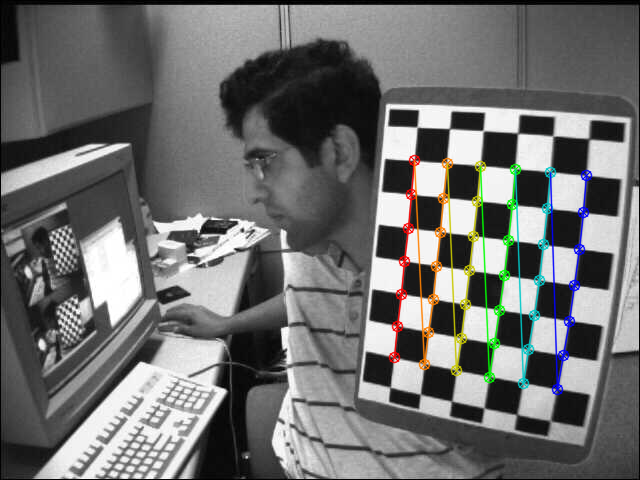

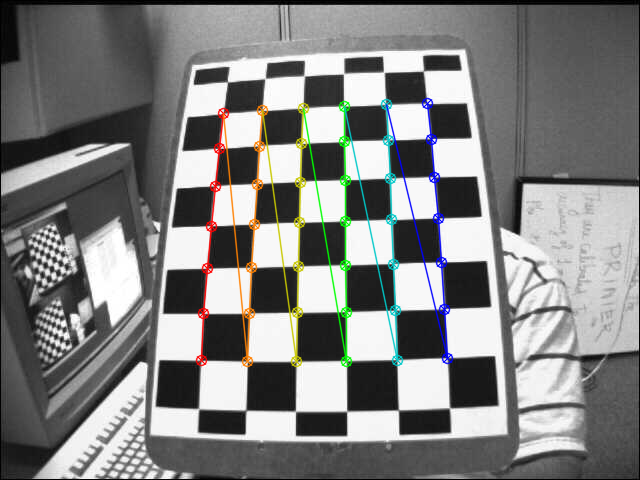

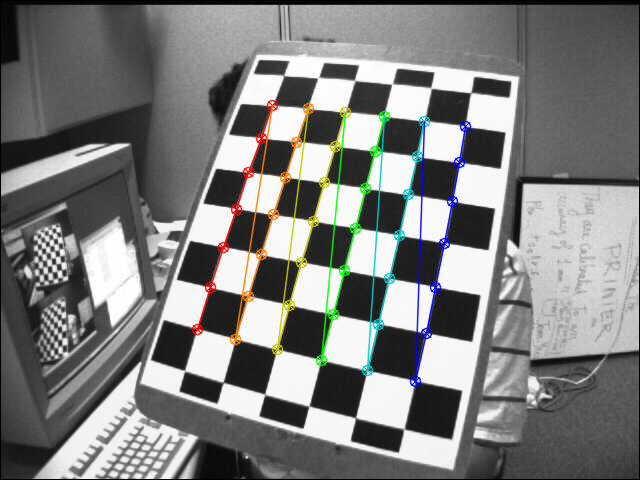

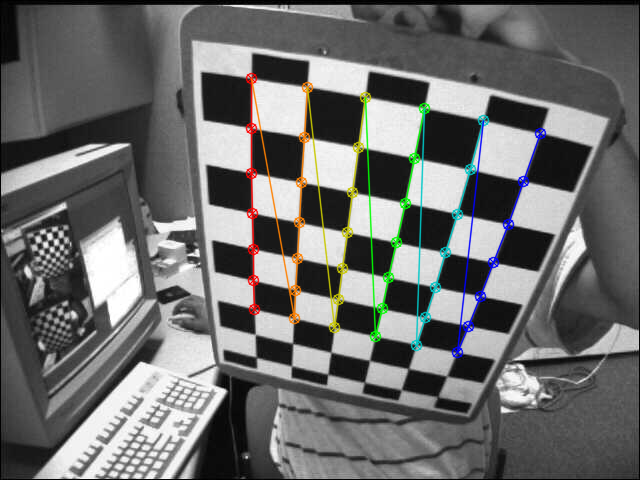

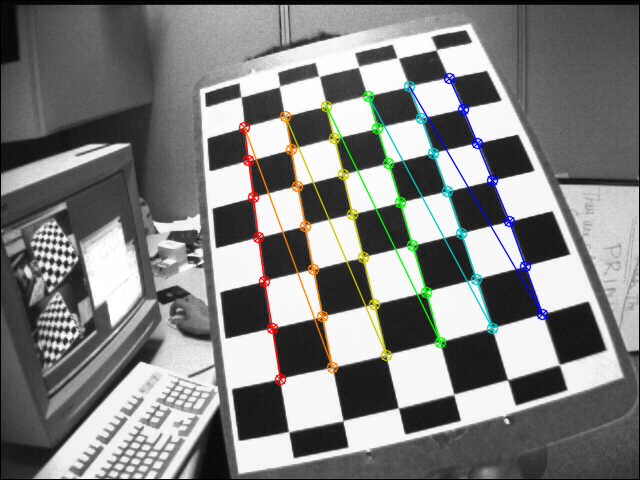

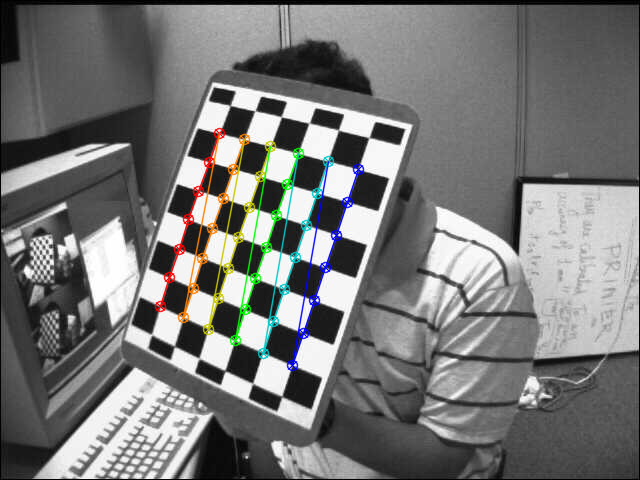

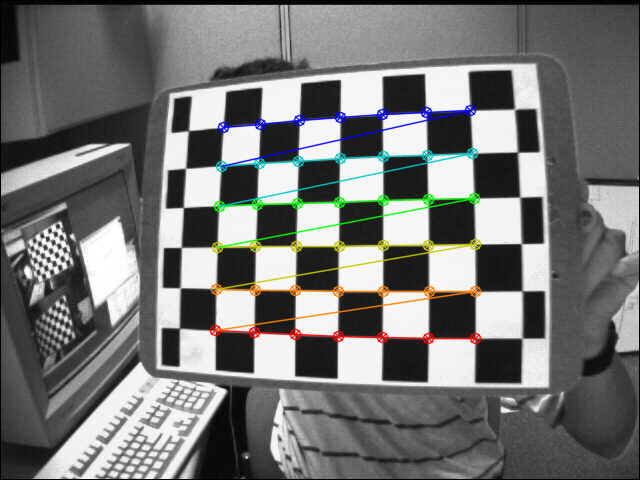

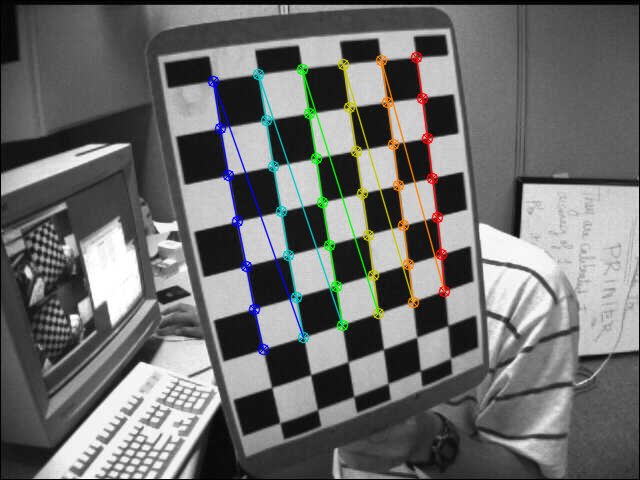

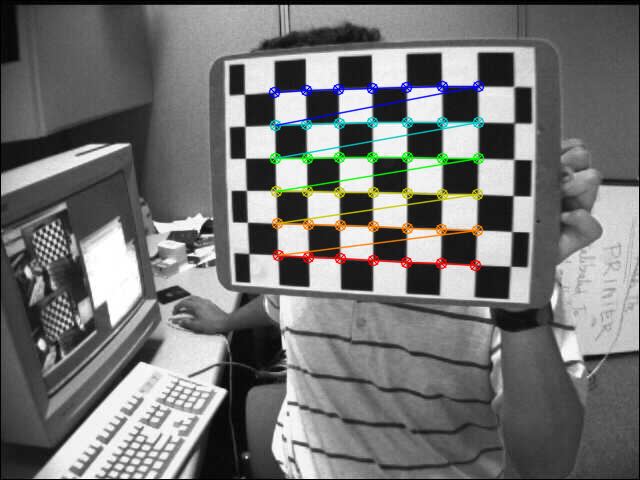

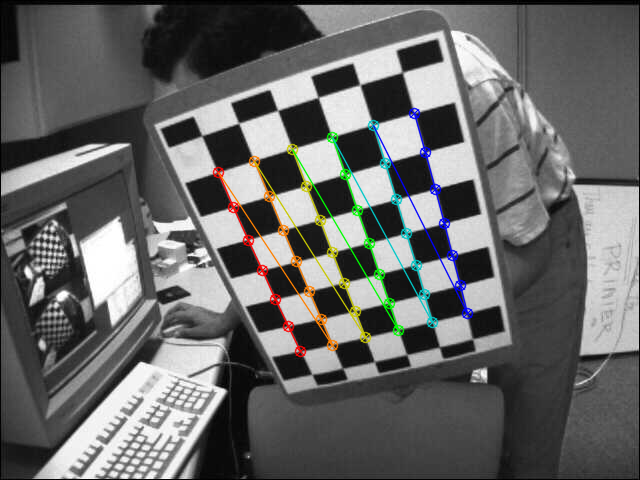

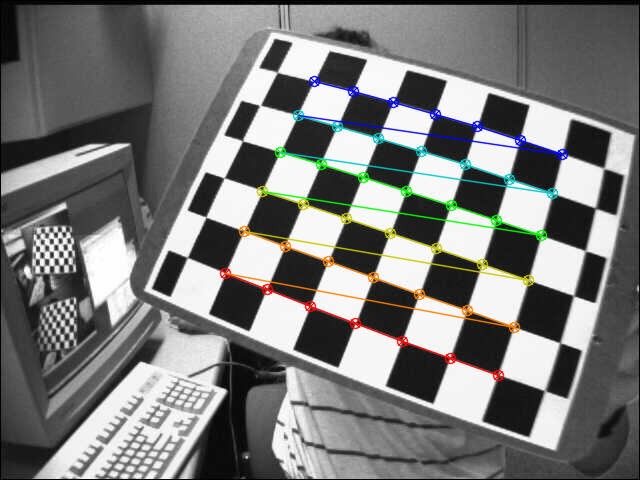

In [2]:
import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow



# pontos 3D (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

objpoints = [] # pontos 3D dos objetos
imgpoints = [] # pontos 3D das imagens

images = glob.glob('*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Encontra 42 (7x6) corners no tabuleiro de xadrez
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # Caso encontrados, adiciona pontos 3D e 2D nas listas objpoints e imgpoints
    # com refinamento da busca
    if ret == True:
        objpoints.append(objp)
        # critério de término de busca
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Desenha e mostra os corners nas diversas imagens
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        cv2_imshow(img)



In [3]:
_,mtx,_,_,_ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print('Matriz de câmera:')
print(mtx)

Matriz de câmera:
[[534.07088623   0.         341.53407107]
 [  0.         534.11914798 232.94565221]
 [  0.           0.           1.        ]]


#### <b> EXERCÍCIO </b>

A partir do resultado de calibração anterior, mostre qual é a distância focal desta câmera e qual é o seu centro óptico.

In [ ]:
#implemente seu código aqui

#distancia focal =~ 534

#centro optico: cx =~341.5 e cy =~233

#só para pinhole

#### <b> EXERCÍCIO </b>

Na implementação anterior, utilizamos 13 imagens para obter todos os pontos de referência para calibração. Porém, seria possível obter uma estimativa usando apenas uma imagem. Escolha uma das imagens e faça a calibração a partir dela. Compare com o resultado obtido anteriormente. 

In [ ]:
#implemente seu código aqui

import numpy as np
import cv2
import glob
from google.colab.patches import cv2_imshow



# pontos 3D (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

objpoints = [] # pontos 3D dos objetos
imgpoints = [] # pontos 3D das imagens

images = glob.glob('*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Encontra 42 (7x6) corners no tabuleiro de xadrez
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # Caso encontrados, adiciona pontos 3D e 2D nas listas objpoints e imgpoints
    # com refinamento da busca
    if ret == True:
        objpoints.append(objp)
        # critério de término de busca
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Desenha e mostra os corners nas diversas imagens
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        cv2_imshow(img)


### <b> DISTORÇÃO DAS LENTES </b>

O cálculo anterior não levou em conta a distorção provocada pelas lentes da câmera. Abaixo, mostramos novamente o efeito provocado pela distorção das lentes:

<img src="https://docs.opencv.org/3.4/calib_radial.jpg"> </img>

Os coeficiente de distorção podem ser calculados pela fórmula abaixo (3 coeficientes):


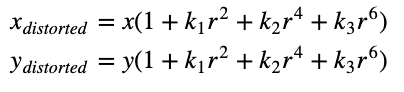

In [ ]:
img = cv2.imread('coefs.png')
cv2_imshow(img)

Para saber se há distorção, podemos consultar outro parâmetro de retorno da função (dist). A OpenCV trabalha com 5 coeficientes de distroção ao invés de 3.

In [ ]:
_,mtx,dist,_,_ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print(dist)

[[-2.92971621e-01  1.07706887e-01  1.31038490e-03 -3.11022977e-05
   4.34799142e-02]]


Se o vetor de distorção for diferente de zero, podemos corrigir a matriz de câmera utilizando o método getOptimalNewCameraMatrix:

In [ ]:
_,mtx,dist,_,_ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
img = cv2.imread('left01.jpg')
h, w = img.shape[:2]
newcameramtx,roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
print(newcameramtx)

[[458.64099121   0.         343.09157581]
 [  0.         457.19467163 233.83376475]
 [  0.           0.           1.        ]]


#### <b> EXERCÍCIO </b>

Das treze imagens apresentadas, verifique em qual delas é possível perceber distorção provocada pelas lentes da câmera.

In [ ]:
#implemente seu código aqui

### <b> CORREÇÃO DAS IMAGENS COM DISTORÇÃO DE LENTES </b>

Uma vez realizada uma calibração ótima, podemos corrigir a distorção de lentes nas imagens, deixando as linhas do tabuleiro "retas".


In [ ]:
_,mtx,dist,_,_ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
img = cv2.imread('left01.jpg')
h, w = img.shape[:2]
newcameramtx,roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# corrige distorção
imgc = cv2.undistort(img, mtx, dist, None, newcameramtx)

# corta a imagem segundo o ROI recebido
x,y,w,h = roi
imgc = imgc[y:y+h, x:x+w]

cv2_imshow(img)
cv2_imshow(imgc)


#### <b> EXERCÍCIO </b>

Corrigir as distorções das treze imagens fornecidas, armazenando-as em disco.

In [ ]:
#implemente seu código aqui